In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

In [2]:
detData = pd.read_csv("../trackingml/detectors.csv")

In [3]:
layerData = [
    detData[(detData["volume_id"] == 8) & (detData["layer_id"] == 2) & (detData["cz"] == 35)],
    detData[(detData["volume_id"] == 8) & (detData["layer_id"] == 4) & (detData["cz"] == 35)],
    detData[(detData["volume_id"] == 8) & (detData["layer_id"] == 6) & (detData["cz"] == 35)],
    detData[(detData["volume_id"] == 8) & (detData["layer_id"] == 8) & (detData["cz"] == 35)],
    detData[(detData["volume_id"] == 13) & (detData["layer_id"] == 2) & (detData["cz"] == 0)],
    detData[(detData["volume_id"] == 13) & (detData["layer_id"] == 4) & (detData["cz"] == 0)],
    detData[(detData["volume_id"] == 13) & (detData["layer_id"] == 6) & (detData["cz"] == 0)],
    detData[(detData["volume_id"] == 13) & (detData["layer_id"] == 8) & (detData["cz"] == 0)],
    detData[(detData["volume_id"] == 17) & (detData["layer_id"] == 2) & (detData["cz"] == 0)],
    detData[(detData["volume_id"] == 17) & (detData["layer_id"] == 4) & (detData["cz"] == 0)],
]
nModulesInPhi = []
for ld in layerData:
    nModulesInPhi.append(len(ld))
nModulesInPhi


[16, 32, 52, 78, 40, 56, 78, 102, 120, 152]

In [4]:
from detectorGeo import detectorGeo
detGeo = detectorGeo()
detGeo.initFromFile(layerData,nModulesInPhi)

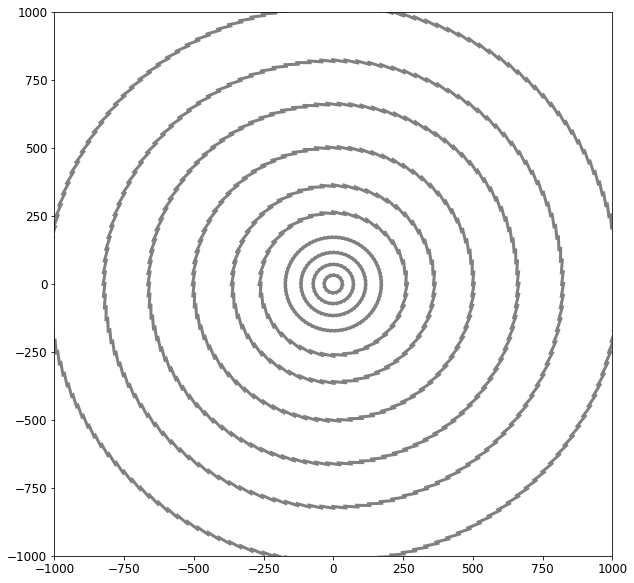

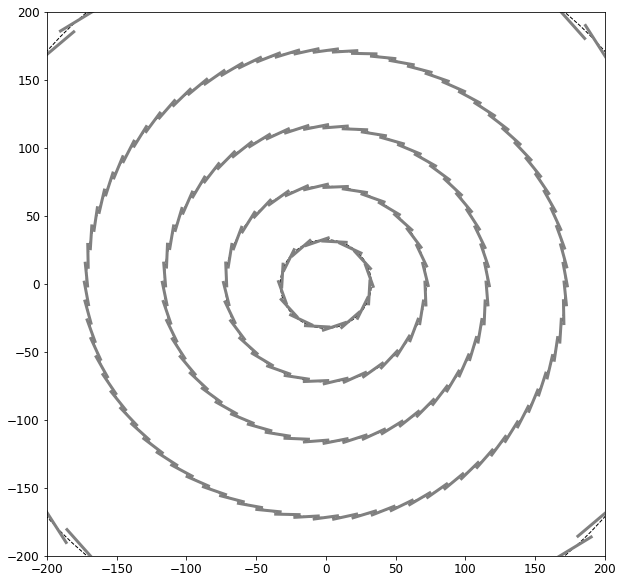

In [5]:
fig, ax = plt.subplots(1, figsize=(10,10))
zoom = 1000
ax.set_xlim((-1*zoom, zoom))
ax.set_ylim((-1*zoom, zoom))

detGeo.drawDetector(ax,True)
    
fig, ax = plt.subplots(1, figsize=(10,10))
zoom = 200
ax.set_xlim((-1*zoom, zoom))
ax.set_ylim((-1*zoom, zoom))

detGeo.drawDetector(ax,True)
  

# Make some Towers

In [6]:
fig, ax = plt.subplots(1, figsize=(10,10))
zoom = 1000
ax.set_xlim((0, zoom))
ax.set_ylim((-zoom/2, zoom/2))
nSSperLayer=[30,30,30,30,30,30,30,30,30,30]


detGeo.makeTower(phiCenter=0*np.pi/12,  phiWidth=np.pi/2, nSS=nSSperLayer)
detGeo.drawTower(ax,detailed=True)

# Get sometracks for pattern matching

In [7]:
np.random.seed(42)

solutions_test  = []

phiRange = (-3*np.pi/12, 3*np.pi/12)


for trkI in range(10):
    
    ptInv = np.random.uniform(0.01*0.001,1.33*0.001,1)[0]
    phi   = np.random.uniform(phiRange[0],phiRange[1],1)[0]
    q     = 2*np.random.randint(0,2,1)[0]-1
    pt = 1./ptInv

    xHits, yHits, modulesHit, actualHits = detGeo.getHits(pt,phi,q)

    solutions_test.append([xHits,yHits,pt,phi,q,modulesHit,actualHits])

/Users/johnda/MachineLearning/TrackingToy/TrackHelper.py:133: RuntimeWarning: invalid value encountered in sqrt
  closure_raw_pp = abs(yints_raw-trk_yc+np.sqrt(trk_rc2-(xints_p_raw-trk_xc)**2))
/Users/johnda/MachineLearning/TrackingToy/TrackHelper.py:134: RuntimeWarning: invalid value encountered in sqrt
  closure_raw_pm = abs(yints_raw-trk_yc-np.sqrt(trk_rc2-(xints_p_raw-trk_xc)**2))
/Users/johnda/MachineLearning/TrackingToy/TrackHelper.py:135: RuntimeWarning: invalid value encountered in sqrt
  closure_raw_mp = abs(yints_raw-trk_yc+np.sqrt(trk_rc2-(xints_m_raw-trk_xc)**2))
/Users/johnda/MachineLearning/TrackingToy/TrackHelper.py:136: RuntimeWarning: invalid value encountered in sqrt
  closure_raw_mm = abs(yints_raw-trk_yc-np.sqrt(trk_rc2-(xints_m_raw-trk_xc)**2))


# Lets plot the SSIDs that are Hit as a sanity check

In [8]:
fig, ax = plt.subplots(1, figsize=(10,10))
zoom = 1500
ax.set_xlim((0, zoom))
ax.set_ylim((-zoom/2, zoom/2))

detGeo.drawTower(ax,detailed=True)
for sItr in range(10):
    s = solutions_test[sItr]

    if not detGeo.hitsAllInTower(s[6]): continue

    color = "b" if (s[4] < 0) else "r"
    plt.plot(s[0],s[1],color)
    
    hitList = []
    realHits = s[6]
    for rHit in realHits:
        # hitID / hit-X / hit-Y / hit-Z/ volume_id /  layer_id 
        hitList.append(  [1,rHit[1],rHit[2], None, rHit[0][0], rHit[0][1] ] )
        

    hitsWithSSIDs = detGeo.addSSIDs(hitList)

    # Get to format of logicallayer_id / SSID
    thisSSIDs = np.array(hitsWithSSIDs)[:,6:8]
    
    plt.plot(s[0],s[1],'ko')
    detGeo.drawSSIDs(ax,thisSSIDs)
    
    #print(hits)
    for rH in realHits:
        plt.plot(rH[1],rH[2],'bo')


# OK Lets make some patterns 

In [9]:
from TrackHelper import patternID

In [10]:
import os
import pickle
if os.path.isfile("patternsKaggle2DGeo_75k.pickle"):
    print("Loading Patterns")
    with open('patternsKaggle2DGeo_75k.pickle', 'rb') as handle:
        patternsBankLoaded = pickle.load(handle)
    
    patternBank         = patternsBankLoaded["bank"]
    passedTracksSamples = patternsBankLoaded["passedTracks"]
    patternBankSize     = patternsBankLoaded["bankSize"]


else:
    print("Making Patterns")
    np.random.seed(42)

    nTrk_pattGen = int(7.5e4)#int(7.5e2)
    solutions_pattGen  = []

    phiRange = (-3*np.pi/12, 3*np.pi/12)
    
    
    for trkI in range(nTrk_pattGen):
        
        ptInv = np.random.uniform(0.01*0.001,1.33*0.001,1)[0]
        phi   = np.random.uniform(phiRange[0],phiRange[1],1)[0]
        q     = 2*np.random.randint(0,2,1)[0]-1
        pt = 1./ptInv
        
        xHits, yHits, modulesHit, actualHits = detGeo.getHits(pt,phi,q)
        
        solutions_pattGen.append([xHits,yHits,pt,phi,q,modulesHit,actualHits])

    # The pattern bank
    patternBank = {}

    # For plotting
    passedTracks = 0
    passedTracksSamples = np.array([],float)
    patternBankSize = np.array([],float)

    for sItr in range(nTrk_pattGen):
        s = solutions_pattGen[sItr]

        if not detGeo.hitsAllInTower(s[6]): continue

        hitList = []
        realHits = s[6]
        for rHit in realHits:
            # hitITr / hit-X / hit-Y / hit-Z / volumeID / layerID 
            hitList.append(  [1,rHit[1],rHit[2], None, rHit[0][0], rHit[0][1] ] )
                
        passedTracks += 1
        
        hitsWithSSIDs = detGeo.addSSIDs(hitList)
        
        # Get SSIds perlayer
        thisSSIDs = [] 
        for _ in range(len(detGeo.layers)): thisSSIDs.append([])
            
        for hinfo in hitsWithSSIDs:
            thisSSIDs[hinfo[6]].append(hinfo[7])

        
        #
        #  Need one SSIDS per layer
        #        
        goodTrack = True
        for layItr, layerSSIDs in enumerate(thisSSIDs):
            if len(layerSSIDs) == 0:  
                #print("Using PS hit instead")
                #thisSSIDs[layItr].append()
                goodTrack = False
                #fig, ax = plt.subplots(1, figsize=(10,10))
                #ax.set_xlim((0, 3))
                #ax.set_ylim((-1.5, 1.5))
                
                #detGeo.drawTower(ax,detailed=True)
                #color = "b" if (s[4] < 0) else "r"
                #plt.plot(s[0],s[1],color)
                
            elif len(layerSSIDs) == 1:  
                pass # all good
            else:
                while(not len(thisSSIDs[layItr]) == 1):
                    thisSSIDs[layItr].pop(-1)
        if not goodTrack: continue
        thisPatternID = patternID(thisSSIDs,nSSperLayer)
        
        if thisPatternID not in patternBank:
            patternBank[thisPatternID] = 0
        
        patternBank[thisPatternID] += 1
        
        # Statistics
        if passedTracks %10 == 0:
            passedTracksSamples = np.append(passedTracksSamples,passedTracks)
            patternBankSize     = np.append(patternBankSize, len(patternBank))

    patternsBankToLoad = {}
    patternsBankToLoad["bank"]         = patternBank
    patternsBankToLoad["passedTracks"] = passedTracksSamples
    patternsBankToLoad["bankSize"]     = patternBankSize
    
    with open('patternsKaggle2DGeo_75k.pickle', 'wb') as handle:
        pickle.dump(patternsBankToLoad, handle, protocol=pickle.HIGHEST_PROTOCOL)        
        
len(patternBank)

Loading Patterns


7657

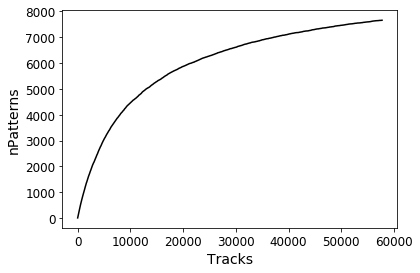

In [11]:
plt.plot(passedTracksSamples,patternBankSize,"k")
plt.xlabel("Tracks")
plt.ylabel("nPatterns")

# OK Lets try to do pattern matching with the pattern bank

In [12]:
def getEvent(nTrks, phiCenter, phiWidth, det_geo, randSeed = 42, debug=False):
    np.random.seed(randSeed)

    # Kaggle formats
    eventParticles = []
    eventTruth = []
    eventHits = []

    # For plotting 
    solutions = []
    
    hitID = 0
    trkID = 0
    phiRange = (phiCenter-phiWidth/2, phiCenter+phiWidth/2)

    if debug: print("phiRange is",phiRange)
    nTrkPerPhiRegion = int(10) # with 50 tracks total ~10 in a phi slice
    for trkI in range(nTrks):
        ptInv = np.random.uniform(0.01*0.001,1.33*0.001,1)[0]
        phi   = np.random.uniform(phiRange[0],phiRange[1],1)[0]
        q     = 2*np.random.randint(0,2,1)[0]-1
        pt = 1./ptInv

        xHits, yHits, modulesHit, actualHits = det_geo.getHits(pt,phi,q)

        if not det_geo.hitsAllInTower(actualHits): 
            if debug: print("Skipping",phi)
            continue
        

        trkID += 1
        eventParticles.append((trkI,pt,phi,q,6))
        solutions.append([xHits,yHits,pt,phi,q,modulesHit,actualHits])
        for thisHit in actualHits:
            # hit_id, particle_id, tx, ty, tz, weight (=1 for now)
            eventTruth.append([hitID,trkID,thisHit[1],thisHit[2],None,1.0])
            eventHits .append((hitID,thisHit[1],thisHit[2],None,thisHit[0][0],thisHit[0][1],thisHit[0][2])) 
            hitID += 1


    recHits = np.array(eventHits)
    shuffle_index = np.random.permutation(len(recHits))
    recHits = recHits[shuffle_index]

    return recHits, eventTruth, eventParticles, solutions

In [13]:
recHits, eventTruth, eventPartilces, solutions = getEvent(10, 0, np.pi/4, detGeo, randSeed=101)

recHits[0:10] 

/Users/johnda/MachineLearning/TrackingToy/TrackHelper.py:133: RuntimeWarning: invalid value encountered in sqrt
  closure_raw_pp = abs(yints_raw-trk_yc+np.sqrt(trk_rc2-(xints_p_raw-trk_xc)**2))
/Users/johnda/MachineLearning/TrackingToy/TrackHelper.py:134: RuntimeWarning: invalid value encountered in sqrt
  closure_raw_pm = abs(yints_raw-trk_yc-np.sqrt(trk_rc2-(xints_p_raw-trk_xc)**2))
/Users/johnda/MachineLearning/TrackingToy/TrackHelper.py:135: RuntimeWarning: invalid value encountered in sqrt
  closure_raw_mp = abs(yints_raw-trk_yc+np.sqrt(trk_rc2-(xints_m_raw-trk_xc)**2))
/Users/johnda/MachineLearning/TrackingToy/TrackHelper.py:136: RuntimeWarning: invalid value encountered in sqrt
  closure_raw_mm = abs(yints_raw-trk_yc-np.sqrt(trk_rc2-(xints_m_raw-trk_xc)**2))


array([[79, 356.310693127032, 64.99609641285133, None, 13.0, 4.0, 590.0],
       [16, 265.2340322008619, -0.9988251206100358, None, 13.0, 2.0,
        420.0],
       [78, 261.7731585898579, 35.59292104522774, None, 13.0, 2.0, 421.0],
       [33, 769.8970766341138, 297.48916652870275, None, 17.0, 2.0,
        1267.0],
       [31, 479.8054340299414, 153.80216052003152, None, 13.0, 6.0,
        823.0],
       [64, 164.52965583645417, -50.85830848027899, None, 8.0, 8.0,
        582.0],
       [49, 71.90037297785, 4.990274499890688, None, 8.0, 4.0, 241.0],
       [43, 621.4808798000373, -237.79606363983385, None, 13.0, 8.0,
        1065.0],
       [65, 249.30591236193897, -73.28685006220576, None, 13.0, 2.0,
        419.0],
       [66, 349.0229072570137, -96.48102359992322, None, 13.0, 4.0,
        586.0]], dtype=object)

In [14]:
fig, ax = plt.subplots(1, figsize=(10,10))
zoom = 1200
ax.set_xlim((0, zoom))
ax.set_ylim((-zoom/2, zoom/2))

detGeo.drawTower(ax,detailed=True)
for sItr in range(len(solutions)):
    s = solutions[sItr]

    hitListTrk = []

    realHits = s[6]
    for rHit in realHits:
        # hitITr / hit-X / hit-Y / hit-Z / volumeID / layerID 
        hitListTrk.append(  [1,rHit[1],rHit[2], None, rHit[0][0], rHit[0][1] ] )
        
    color = "b" if (s[4] < 0) else "r"
    plt.plot(s[0],s[1],color)
    
    hitsWithSSIDs = detGeo.addSSIDs(hitListTrk)

    # Get to format of logicallayer_id / SSID
    thisSSIDs = np.array(hitsWithSSIDs)[:,6:8]
    
    detGeo.drawSSIDs(ax,thisSSIDs)


In [15]:
#print(recHits[0])
hitsAndSSIDS = detGeo.addSSIDs(recHits,debug=False)
#print(hitsAndSSIDS[0])
detGeo.DOWrite(hitsAndSSIDS)

In [16]:
patterns = patternBank.keys()
matchedPatterns = []
for p in patterns:

    if detGeo.isPatternFired(p): 
        matchedPatterns.append(p)

print(matchedPatterns)

[24222119181716161515, 22212120202019191919, 22212120202020191919, 25222119181716161515, 22222120202019191919, 23211917151413131212, 24222119181716161615, 9101112131414151515, 24211917151413131212, 23211917151414131212, 11101009090909090808, 15161616161616161616, 24221917161413131212, 11101010090909090808, 25242322222120202020, 5060809101011111212, 23211917161413131212, 25222119181716151515, 11111010090909090808, 25221917161413131212, 24222119181716151515, 24211917161413131212, 9111112131414151515, 22212120202020202020, 22211919181716161616, 23222120202019191919]


In [17]:
from TrackHelper import getSSIDS

24222119181716161515
22212120202019191919
22212120202020191919
25222119181716161515
22222120202019191919
23211917151413131212
24222119181716161615
9101112131414151515
24211917151413131212
23211917151414131212
11101009090909090808
15161616161616161616
24221917161413131212
11101010090909090808
25242322222120202020
5060809101011111212
23211917161413131212
25222119181716151515
11111010090909090808
25221917161413131212
24222119181716151515
24211917161413131212
9111112131414151515
22212120202020202020
22211919181716161616
23222120202019191919


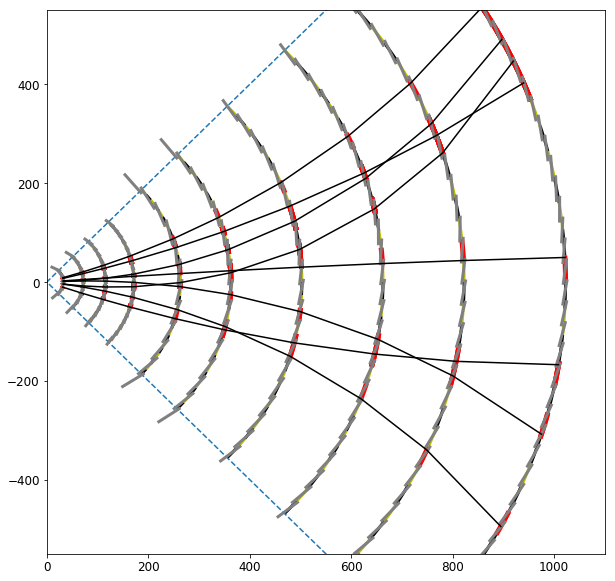

In [18]:
fig, ax = plt.subplots(1, figsize=(10,10))
zoom = 1100
ax.set_xlim((0, zoom))
ax.set_ylim((-zoom/2, zoom/2))


detGeo.drawTower(ax,detailed=True)
for mp in matchedPatterns:
    print(mp)            
    thisSSIDs = getSSIDS(mp,nLay=len(detGeo.layers))
    detGeo.drawSSIDs(ax,thisSSIDs)
    
for sItr in range(len(solutions)):
    s = solutions[sItr]

    color = "k"
    plt.plot(s[0],s[1],color)
    


In [19]:
solns, _  = detGeo.getSolutions(matchedPatterns)
solns.head()


event_id  hit_id  track_id
0         0       1         1
1         0      74         1
2         0       0         1
3         0      73         1
4         0       2         1

In [20]:
from TrackHelper import getTruthDF


In [21]:
truth = getTruthDF(eventTruth)
truth.head()

hit_id particle_id weight
0      0           1      1
1      1           1      1
2      2           1      1
3      3           1      1
4      4           1      1

In [22]:
import score
score.score_event(truth,solns)

0.8333333333333333

# OK pretty clear differnet regions are working, lets to the whole event

/Users/johnda/MachineLearning/TrackingToy/TrackHelper.py:133: RuntimeWarning: invalid value encountered in sqrt
  closure_raw_pp = abs(yints_raw-trk_yc+np.sqrt(trk_rc2-(xints_p_raw-trk_xc)**2))
/Users/johnda/MachineLearning/TrackingToy/TrackHelper.py:134: RuntimeWarning: invalid value encountered in sqrt
  closure_raw_pm = abs(yints_raw-trk_yc-np.sqrt(trk_rc2-(xints_p_raw-trk_xc)**2))
/Users/johnda/MachineLearning/TrackingToy/TrackHelper.py:135: RuntimeWarning: invalid value encountered in sqrt
  closure_raw_mp = abs(yints_raw-trk_yc+np.sqrt(trk_rc2-(xints_m_raw-trk_xc)**2))
/Users/johnda/MachineLearning/TrackingToy/TrackHelper.py:136: RuntimeWarning: invalid value encountered in sqrt
  closure_raw_mm = abs(yints_raw-trk_yc-np.sqrt(trk_rc2-(xints_m_raw-trk_xc)**2))


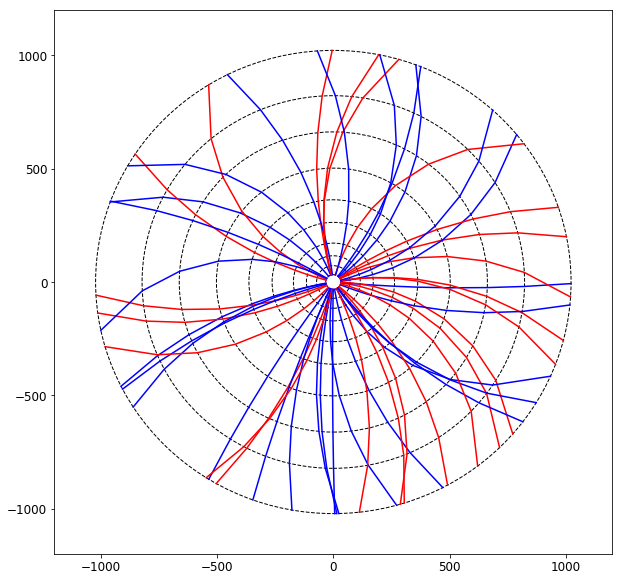

In [23]:
fig, ax = plt.subplots(1, figsize=(10,10))
zoom=1200
ax.set_xlim((-zoom, zoom))
ax.set_ylim((-zoom, zoom))

detGeo_All = detectorGeo()
detGeo_All.initFromFile(layerData,nModulesInPhi)
detGeo_All.makeTower(0,  2*np.pi, nSS=nSSperLayer)

detGeo_All.drawDetector(ax)

recHits_All, eventTruth_All, eventPartilces_All, solutions_All = getEvent(50, 0, 2*np.pi, detGeo_All,randSeed=2)


for sItr in range(len(solutions_All)):
    s = solutions_All[sItr]
    


    color = "b" if (s[4] < 0) else "r"
    plt.plot(s[0],s[1],color)

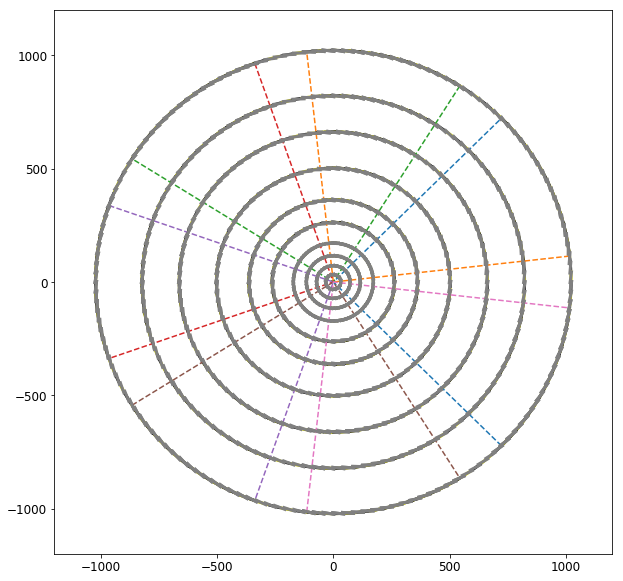

In [24]:

fig, ax = plt.subplots(1, figsize=(10,10))
zoom=1200
ax.set_xlim((-zoom, zoom))
ax.set_ylim((-zoom, zoom))
nTowers = 7
towerWidth = np.pi/2

towers = []
for iT in range(nTowers):
    towers.append(detectorGeo())
    towers[-1].initFromFile(layerData,nModulesInPhi)
    towers[-1].makeTower(2*iT*np.pi/nTowers, towerWidth, nSS=nSSperLayer)

    towers[-1].drawTower(ax,detailed=True)

#for sItr in range(50):
#    s = solutions_All[sItr]
#
#    color = "b" if (s[4] < 0) else "r"
#    plt.plot(s[0],s[1],"ro")

In [25]:
import pandas as pd

evt_id_all = []
hit_id_all = []
trk_id_all = []

patterns = patternBank.keys()

for t in towers:
    hitsAndSSIDS_All = t.addSSIDs(recHits_All,filterOnTower=True)
    t.DOWrite(hitsAndSSIDS_All)


    thisMatchedPatterns = []
    for p in patterns:

        if t.isPatternFired(p): 
            thisMatchedPatterns.append(p)
    
    if len(trk_id_all): trkID = trk_id_all[-1]+1
    else:               trkID = 0
    
    thisSolns, thisSolnsDetails = t.getSolutions(thisMatchedPatterns,trkIDInit=trkID)
    
    # need over lap removal!
    
    evt_id_all += thisSolnsDetails[0]
    hit_id_all += thisSolnsDetails[1]
    trk_id_all += thisSolnsDetails[2]    

solnDictAll = {"event_id" : pd.Series(evt_id_all),
               "hit_id" : pd.Series(hit_id_all),
               "track_id" : pd.Series(trk_id_all),
              }

solnsAll = pd.DataFrame(solnDictAll)

In [26]:
truth_All = getTruthDF(eventTruth_All)
score.score_event(truth_All,solnsAll)

0.8774834437086092

In [27]:
# Need to remove overlap !
solns["hit_id"].value_counts()

95    1
33    1
24    1
25    1
26    1
27    1
28    1
29    1
30    1
31    1
32    1
34    1
45    1
35    1
36    1
37    1
38    1
39    1
40    1
41    1
42    1
43    1
23    1
22    1
21    1
20    1
1     1
2     1
3     1
4     1
     ..
88    1
89    1
90    1
91    1
92    1
93    1
73    1
72    1
71    1
69    1
48    1
49    1
50    1
51    1
52    1
53    1
54    1
55    1
56    1
57    1
58    1
59    1
60    1
61    1
62    1
63    1
64    1
65    1
66    1
0     1
Name: hit_id, Length: 93, dtype: int64